# HR Separation 
## Assessment of the survival models (and my modifications to lifelines)

## March 16, 2016

The issue is that my predictions, don't necessarily match those of the actual separation in 2015.

Let's investigate this.

In [1]:
stgdir1local = u'C:/Users/kesj/Documents/projects/HRattrition/survival'
repodir = u'C:/Users/kesj/code/'

In [2]:
import os,sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [3]:
os.chdir(stgdir1local)

## load the model

In [4]:
import pickle

In [5]:
mdl_filename='separation_cf4.pkl'
sep_mdl = pickle.load(open(mdl_filename,'rb'))

In [6]:
import lifelines as ll

### Load the dataset

In [7]:
empl1 = pd.read_csv('after2001_v8.csv',dtype={'KEY':np.str,'EEO1CODE':np.str},parse_dates=['birth_tstmp','term_tstmp','hire_tstmp'])

In [8]:
empl1.EEO1CODE.unique()

array(['2', '5', '1', '4', '3', '7', '6', 'N', 'L', '8'], dtype=object)

In [9]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn import ensemble, metrics, cross_validation

In [10]:
os.chdir(repodir)
import bear.bear as br
#os.chdir(stgdir1local)
reload(br)
os.chdir(stgdir1local)

In [11]:
current = empl1[empl1.status==0].copy()
print(len(empl1),len(current))
#empl1[empl1.status==0].to_csv('current_v8.ssv',sep=';',index=False)

(134189, 69475)


In [12]:
#os.chdir('../reduced/')
#empl2 = pd.read_csv('after2001_v3.csv',dtype={'KEY':np.str})
#print(empl2.shape)

In [13]:
[col for col in empl1.columns if col.endswith('DT')]

['HIRE_DT', 'LAST_HIRE_DT', 'SERVICE_DT', 'TERMINATION_DT']

In [14]:
empl1.shape

(134189, 126)

## Define the Interesting Extended Functions and JOBCODES

In [15]:
#interesting_extended_functions = [892,71, 816, 909,910,517,835]
extFuncDict ={}
extFuncDict[892]='CCC Sales'
extFuncDict[71]='CCC Service'
extFuncDict[816]='Life Health Response Center'
#(00816)
extFuncDict[909]='Enterprise Auto Express'
extFuncDict[910]='Enterprise ILR' 
extFuncDict[517]='State Farm Bank'
extFuncDict[835]='SFPP'
interesting_extended_functions = extFuncDict.keys()
extFuncDict

{71: 'CCC Service',
 517: 'State Farm Bank',
 816: 'Life Health Response Center',
 835: 'SFPP',
 892: 'CCC Sales',
 909: 'Enterprise Auto Express',
 910: 'Enterprise ILR'}

In [20]:
jobCodeDict = {}
jobCodeDict[6200]= 'CCC Service Rep'
jobCodeDict[1876]= 'CCC Sales Rep'
jobCodeDict[1009]='CLaim Associate-ILR'
jobCodeDict[986]='CLaim Team Manager-ILR'
jobCodeDict[983]='Claim Associate-Express'
jobCodeDict[984]='Claim Associate-Express'
jobCodeDict[2638]='Life Customer Service Asst'
jobCodeDict[2639]='Life Customer Service Asst'
jobCodeDict[2641]='Life Customer Service Asst'
jobCodeDict[4105]= 'SFPP Account Rep'
jobCodeDict[851]= 'Bank Customer Service Rep'
jobCodeDict[852]= 'Bank Customer Service Rep'
jobCodeDict[853]= 'Bank Customer Service Rep'
interesting_jobcodes =  jobCodeDict.keys()
jobCodeDict

{851: 'Bank Customer Service Rep',
 852: 'Bank Customer Service Rep',
 853: 'Bank Customer Service Rep',
 983: 'Claim Associate-Express',
 984: 'Claim Associate-Express',
 986: 'CLaim Team Manager-ILR',
 1009: 'CLaim Associate-ILR',
 1876: 'CCC Sales Rep',
 2638: 'Life Customer Service Asst',
 2639: 'Life Customer Service Asst',
 2641: 'Life Customer Service Asst',
 4105: 'SFPP Account Rep',
 6200: 'CCC Service Rep'}

## Create an overall KMF for separation

In [21]:
empl1.terminated.value_counts()

0    84338
1    49851
Name: terminated, dtype: int64

In [17]:
empl1.retired.value_counts()

0    119326
1     14863
Name: retired, dtype: int64

In [16]:
empl1.sep_status.value_counts()

0    69475
1    43198
2    21516
Name: sep_status, dtype: int64

In [19]:
pd.crosstab(empl1.retired,empl1.status)

status,0,1
retired,,
0,69475,49851
1,0,14863


In [35]:
kmf_all = ll.KaplanMeierFitter()
kmf_all.fit(empl1.Tenure_years,empl1.terminated,label='All post2001 employees')

<lifelines.KaplanMeierFitter: fitted with 134189 observations, 84338 censored>

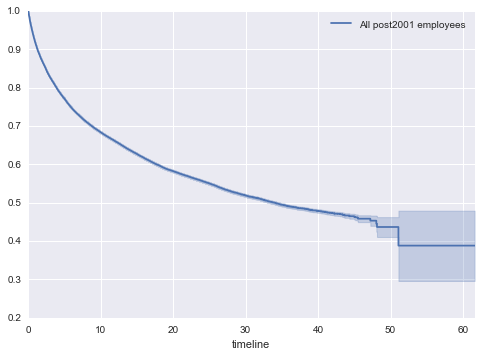

In [36]:
kmf_all.plot()

## Look at the KMF for the particular extended function I'm interested in

In [24]:
kmf_cat = ll.KaplanMeierFitter()

In [37]:
cat_909 = empl1[empl1.EXT_FUNC_ID_SFI==909].copy()
kmf_cat.fit(cat_909.Tenure_years,cat_909.terminated,label='Express')

<lifelines.KaplanMeierFitter: fitted with 3193 observations, 2591 censored>

In [38]:
cat_910 = empl1[empl1.EXT_FUNC_ID_SFI==910].copy()
kmf_cat910 = ll.KaplanMeierFitter()
kmf_cat910.fit(cat_910.Tenure_years,cat_910.terminated,label='ILR')

<lifelines.KaplanMeierFitter: fitted with 3278 observations, 2464 censored>

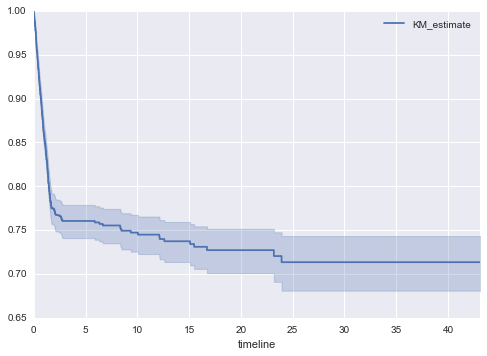

In [26]:
kmf_cat.plot()

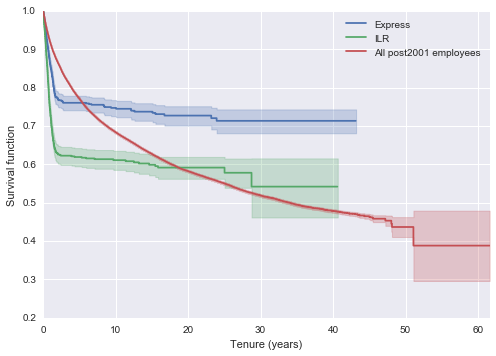

In [39]:
ax = plt.subplot(111)
kmf_cat.plot(ax=ax,label='Express')
kmf_cat910.plot(ax=ax)

kmf_all.plot(ax=ax,label='All post 2001 employees ')
plt.xlabel('Tenure (years)')
plt.ylabel('Survival function')


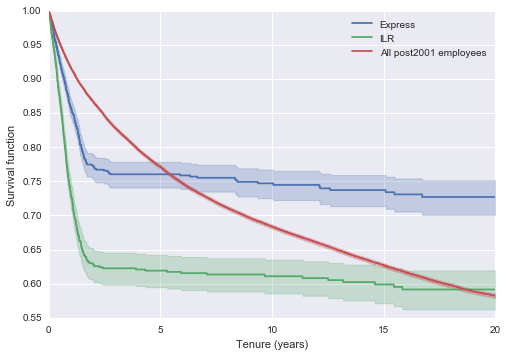

In [43]:
ax = plt.subplot(111)
kmf_cat.plot(ix=slice(0,20),ax=ax)
kmf_cat910.plot(ix=slice(0,20),ax=ax)

kmf_all.plot(ax=ax,ix=slice(0,20))
plt.xlabel('Tenure (years)')
plt.ylabel('Survival function')


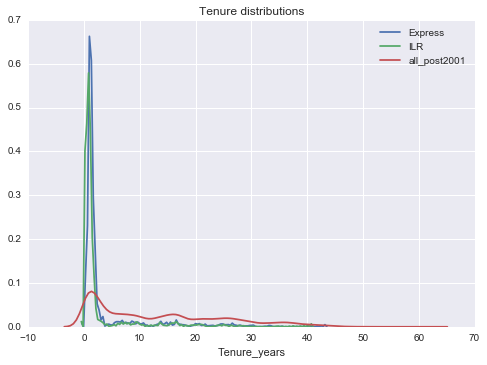

In [41]:
sns.distplot(cat_909.Tenure_years,label='Express',hist=False)
sns.distplot(cat_910.Tenure_years,label='ILR',hist=False)
sns.distplot(empl1.Tenure_years,label='all_post2001',hist=False)
plt.legend()
plt.title('Tenure distributions')

## look at the JOBCODES for this job

In [66]:
cat909_jc = [983,984]
len(empl1[empl1.JOBCODE.isin(cat909_jc)]), len(cat_909)

(2618, 3193)

In [69]:
print("JOBCODE\t counts")
cat_909.JOBCODE.value_counts()

JOBCODE	 counts


984     2471
985      216
1072     201
983      147
500       51
2688      28
1026      23
501       19
2555       8
57         7
902        5
6702       4
2689       3
1028       3
785        3
516        2
6703       1
1009       1
Name: JOBCODE, dtype: int64

In [70]:
print("JOBCODE\t counts")
cat_909[cat_909['status']==0].JOBCODE.value_counts()

JOBCODE	 counts


984     1896
985      214
1072     197
983      143
500       42
2688      27
1026      23
501       17
2555       8
902        5
6702       4
785        3
1028       3
2689       3
57         1
6703       1
Name: JOBCODE, dtype: int64

In [72]:
current[current.EXT_FUNC_ID_SFI==909].JOBCODE.value_counts().sum()

2587L

In [73]:
current.JOBCODE.isin(cat909_jc).sum()

2039

In [75]:
sum(current.JOBCODE==983), sum(current.JOBCODE==984)

(143, 1896)

In [76]:
current[current.EXT_FUNC_ID_SFI==909].GRADE.value_counts()

PA2    1896
MG2     220
RA1     197
PA3     143
PC2      42
RA3      27
MG4      23
PC3      17
UES       8
RA2       8
MG5       5
PA1       1
Name: GRADE, dtype: int64

## Aside
### Look into the accuracy of my models and that of the existing models in relation to the out of time known values from 2015

In [48]:
summary_data = pd.DataFrame(columns = ['GROUP','grp_id','GROUP_TYPE','GroupCount','sep2015','HR1yrsep','SR1yrsep','1yrLB','1yrUB'],
                            data = [['CCC_Service',71,'EXT FUNC',1823,466,210,710,646,770],
['BANK',517,'EXT FUNC',1507,100,94,135,114,157],
['L/H RC',816,'EXT FUNC',376,88,32,71,56,85],
['CCC SALES',892,'EXT FUNC',1636,391,198,524,463,573],
['EXPRESS',909,'EXT FUNC',2587,506,252,63,51,73],
['ILR',910,'EXT FUNC',2462,855,326,472,420,520],
['BANK SERVICE REP',[851,852,853],'JOBCODE',188,27,18,32,7,6],
['CLM ASSOC EXPRESS',[983,984],'JOBCODE',2039,483,229,6,5,6],
['CLM TEAM MGR ILR',[986],'JOBCODE',209,4,7,5,5,5],
['CLM ASSOC ILR',[1009],'JOBCODE',2012,834,306,460,409,506],
['CCC SALES REP',[1876],'JOBCODE',1474,379,190,513,53,561],
['LIFE SERVICE REP',[2638,2639,2641],'JOBCODE',636,106,42,125,107,147],
['SFPP A/C REP',[4105],'JOBCODE',234,51,36,110,96,124],
['CCC SERVICE REP',[6200],'JOBCODE',1472,433,189,648,590,703],
['ALL',0,'ALL', 69476, 5234, 3048, 4579,4093,5042]]
)

In [49]:
summary_data

,GROUP,grp_id,GROUP_TYPE,GroupCount,sep2015,HR1yrsep,SR1yrsep,1yrLB,1yrUB
0,CCC_Service,71,EXT FUNC,1823,466,210,710,646,770
1,BANK,517,EXT FUNC,1507,100,94,135,114,157
2,L/H RC,816,EXT FUNC,376,88,32,71,56,85
3,CCC SALES,892,EXT FUNC,1636,391,198,524,463,573
4,EXPRESS,909,EXT FUNC,2587,506,252,63,51,73
5,ILR,910,EXT FUNC,2462,855,326,472,420,520
6,BANK SERVICE REP,"[851, 852, 853]",JOBCODE,188,27,18,32,7,6
7,CLM ASSOC EXPRESS,"[983, 984]",JOBCODE,2039,483,229,6,5,6
8,CLM TEAM MGR ILR,[986],JOBCODE,209,4,7,5,5,5
9,CLM ASSOC ILR,[1009],JOBCODE,2012,834,306,460,409,506


In [53]:
summary_data['True_AR']=summary_data['sep2015']/summary_data['GroupCount']*100
summary_data.True_AR

0     25.562260
1      6.635700
2     23.404255
3     23.899756
4     19.559335
5     34.727864
6     14.361702
7     23.688082
8      1.913876
9     41.451292
10    25.712347
11    16.666667
12    21.794872
13    29.415761
14     7.533537
Name: True_AR, dtype: float64

In [50]:
summary_data['HR_AR']=summary_data['HR1yrsep']/summary_data['GroupCount']*100
summary_data['SR_AR']=summary_data['SR1yrsep']/summary_data['GroupCount']*100

In [54]:
summary_data[['True_AR','HR_AR','SR_AR']]

,True_AR,HR_AR,SR_AR
0,25.562260,11.519473,38.946791
1,6.635700,6.237558,8.958195
2,23.404255,8.510638,18.882979
3,23.899756,12.102689,32.029340
4,19.559335,9.741013,2.435253
5,34.727864,13.241267,19.171405
6,14.361702,9.574468,17.021277
7,23.688082,11.230996,0.294262
8,1.913876,3.349282,2.392344
9,41.451292,15.208748,22.862823


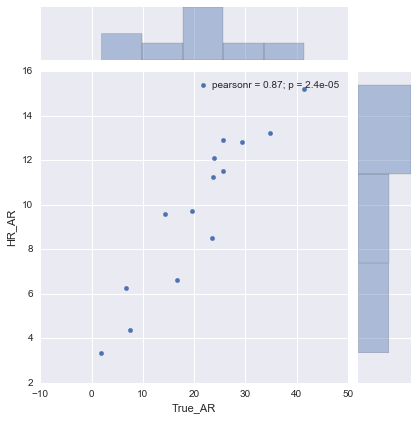

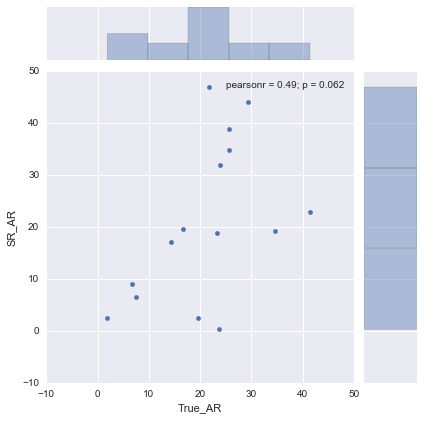

In [56]:
sns.jointplot(x='True_AR',y='HR_AR',data=summary_data)
sns.jointplot(x='True_AR',y='SR_AR',data=summary_data)

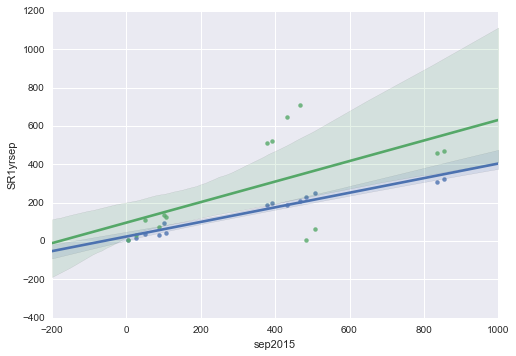

In [65]:
x = np.arange(0,950,1)
#plt.plot(x,x,c='k')
sns.regplot(x='sep2015',y='HR1yrsep',data=summary_data.iloc[:-1])

sns.regplot(x='sep2015',y='SR1yrsep',data=summary_data.iloc[:-1])


## Preprocess this file
1. use the dictonary fro LOC_TYPE_DESCR_SFI 

In [ ]:
loc_descriptions = empl1.LOC_TYPE_DESCR_SFI.unique().tolist()
short_loc_descript = {}
for loc_name in loc_descriptions:
    if loc_name.endswith(')'):
        short_name = loc_name[-4:-1]
        if short_name == 'NCE':
            short_loc_descript[loc_name]='TELE'
        else:
            short_loc_descript[loc_name]=short_name
    elif loc_name.startswith('TELE'):
        short_loc_descript[loc_name]='TELE'
    elif loc_name.endswith('SIU'):
        short_loc_descript[loc_name]='SIU'
    elif loc_name.startswith('OPERATIONS'):
        short_loc_descript[loc_name]='OC'
    elif loc_name.startswith('CORP'):
        short_loc_descript[loc_name]='CORP'
    elif loc_name.endswith('CENTER'):
        short_loc_descript[loc_name]='MC' # marketing center
    elif loc_name.endswith('AFO'):
        short_loc_descript[loc_name]='AFO'
    elif loc_name.endswith('OFFICE'):
        if loc_name.startswith('AGENT'):
            short_loc_descript[loc_name]='AO' # agent office
        elif loc_name.startswith('REGION'):
            short_loc_descript[loc_name]='RO' # regional office
        elif loc_name.startswith('CATA'):
            short_loc_descript[loc_name]='CAT' # catastrophe office
    elif loc_name.startswith('EST'):
        short_loc_descript[loc_name]='EST' # estimating station
    elif loc_name.startswith('ADM'):
        short_loc_descript[loc_name]='ADM' # estimating station
    elif loc_name.startswith('WARE'):
        short_loc_descript[loc_name]='WARE' # estimating station
    elif loc_name.startswith('VAC'):
        short_loc_descript[loc_name]='VAC' # estimating station
    elif loc_name.startswith('MULT-USE'):
        short_loc_descript[loc_name]='MF' # estimating station
    elif loc_name.startswith('MULT-REG'):
        short_loc_descript[loc_name]='MRSF' # estimating station
    else: 
        short_loc_descript[loc_name]='UNK'

print len(short_loc_descript.keys()), len(set(short_loc_descript.values()))

In [ ]:
empl1['loc_desc']=empl1['LOC_TYPE_DESCR_SFI'].apply(lambda x: short_loc_descript[x])


In [ ]:
### Define the categorical columns
cat_cols = br.get_categorical(empl1)
print len(cat_cols)
cat_cols.remove('LOC_TYPE_DESCR_SFI')

In [ ]:
cols_to_drop = ['Age_tdelta','Tenure_tdelta','BIRTHDATE','HIRE_DT','LAST_HIRE_DT','SERVICE_DT','TERMINATION_DT','KEY']

In [ ]:
for col in cols_to_drop:
    cat_cols.remove(col)

In [ ]:
sdf_cat = br.summarize_dataframe(empl1[cat_cols])
max_arity = 33
binary_cat_cols = sdf_cat[sdf_cat.arity==2].feature.tolist()
cat_cols_to_dummy = sdf_cat[(sdf_cat.arity < max_arity) & (sdf_cat.arity > 2)].sort_values(by='arity').feature.tolist()
cat_cols_to_label_encode = sdf_cat[sdf_cat.arity >= max_arity].feature.tolist()
print len(sdf_cat), len(cat_cols_to_label_encode),len(cat_cols_to_dummy), len(binary_cat_cols)



In [ ]:
binary_cat_cols


In [ ]:
cat_cols_to_dummy

In [ ]:
cat_cols_to_label_encode

In [ ]:
binary_cat_cols.remove('FULLPART10')
binary_cat_cols.remove('FULLPART3')
binary_cat_cols.remove('FULLPART5')
binary_cat_cols.remove('PARTFULL10')
binary_cat_cols.remove('PARTFULL5')
binary_cat_cols.remove('PARTFULL3')


In [ ]:
sdf_cat[sdf_cat.arity>=max_arity]

In [ ]:
missing_cols = br.get_columns_with_nulls(empl1)

In [ ]:
all_cols = empl1.columns.tolist()

In [ ]:
missing_cols

In [ ]:
from sklearn.preprocessing import LabelEncoder
#binary_cols = #sdf_cat[sdf_cat.arity == 2].feature.values.tolist()
#binary_cat_cols = cat_cols_to_label_encode[:-3]
print len(binary_cat_cols)
label_encoder = LabelEncoder()
for col in binary_cat_cols:
    print col, len(empl1[col].unique()), empl1[col].unique()
    empl1[col] = label_encoder.fit_transform(empl1[col]) # use sklearn.preprocesing.LabelEncoder()
    

In [ ]:
historical_cols10 = [col for col in all_cols if col.endswith('10')]
mos_cols = [col for col in all_cols if col.endswith('MOS')]
print historical_cols10

print mos_cols
historical_cols5 = [col for col in all_cols if col.endswith('5')]#[:-3]
historical_cols3 =[col for col in all_cols if col.endswith('3')]#[:-4]

len(historical_cols3), len(historical_cols5),len(historical_cols10), len(mos_cols)

In [ ]:
historical_cols = []
historical_cols+=historical_cols3
historical_cols+=historical_cols5
historical_cols+=historical_cols10
print len(historical_cols)

In [ ]:
modeling_cols = [col for col in all_cols if col not in historical_cols]
for col in cols_to_drop:
    modeling_cols.remove(col)

for col in all_cols:
    if col.endswith('tstmp'):
        modeling_cols.remove(col)
        
modeling_cols.remove('hire_age')
modeling_cols.remove('status')
modeling_cols.remove('sep_status')
modeling_cols.remove('retired')
modeling_cols.remove('ANNUAL_RT') # use SAL1 instead

len(modeling_cols)

## Restrict to non-retired
## create a train/test split

In [ ]:
nr_em = empl1[empl1.retired==0].copy()
nr_em.shape

In [ ]:
## break this into a test/train 
# break into evaluation and build sets
print "Starting with subset of {0} employees.".format(len(nr_em))
eval_fraction = 0.20
ne2build, ne2eval = cross_validation.train_test_split(nr_em,test_size=eval_fraction,random_state = 60333)
print "Evaluation set has {0} employees; training set has {1} employees.".format(len(ne2eval),len(ne2build))

In [ ]:
#from sklearn import preprocessing
pipe = Pipeline([("null", br.RemoveAllNull()),  
                 ("label_encode",br.LabelEncodeColumn(cat_cols_to_label_encode)),
                 ("dummy_encode", br.DummyEncodeColumn(cat_cols_to_dummy)),
                 #("survival_encode",SurvivalEncodeColumn(my_label_encode_cols[:5],method='median')),
                 #("cat", br.ConvertCategorical(cate_list, rows_to_scan=0.3)),
                 ("fixout_min",br.FixNumericOutlier(columns_to_fix=['SAL1','MIN_RT_ANNUAL','MERIT1','PERF1'],
                                                    criteria_coef=('percentile',2),
                                                   method='lower',fill_with='nearest_value')),
                  ("fixout_max",br.FixNumericOutlier(columns_to_fix=['MAX_RT_ANNUAL'],criteria_coef=('percentile',2),
                                                   method='both',fill_with='nearest_value')),
                 #("fill_missingzero",FillMissingValue(columns_to_fix=['BOX1','FUNC_CNT','EXTFUNC_CNT','TOTAL_RPT_CNT','DIRECT_RPT_CNT'],fill_value=0)),
                 ("imp_mode",br.ImputeData(columns_to_impute=missing_cols,rows_to_scan=0.8))])
                 

In [ ]:
p_pipe = Pipeline([
                  ("label_encode",br.LabelEncodeColumn(cat_cols_to_label_encode))])

In [ ]:
#%pdb 
ne2b = pipe.fit_transform(ne2build[modeling_cols],ne2build.terminated)
ne2e = pipe.fit(ne2build[modeling_cols],ne2build.terminated).transform(ne2eval[modeling_cols])

In [ ]:
ne2b.shape, ne2e.shape

In [ ]:
transformed_cols2 = ne2b.columns.tolist()
print len(transformed_cols2)

In [ ]:
sep_features= s_cf4.data.columns.tolist()
print len(sep_features)

In [ ]:
s_cf4.print_summary()

## now apply this model to the evaluation set
1. calculate concordance for hold-out set

In [ ]:
from lifelines.utils import concordance_index
def return_concordance(df,model,time_col,event_col):
    c_index = concordance_index(df[time_col].values,
                               model.predict_expectation(df).values.ravel(),
                               df[event_col].values.astype(int))
    return c_index

In [ ]:
sep_cols = [col for col in sep_features]
sep_cols.append('Tenure_years')
sep_cols.append('terminated')

In [ ]:
return_concordance(ne2e[sep_cols],s_cf4,'Tenure_years','terminated')

In [ ]:
## do this for a small set 1st
take20 = ne2e.head(20).copy()

In [ ]:
return_concordance(take20[sep_cols],s_cf4,'Tenure_years','terminated')

## Forecast forward in 1 year intervals
1. identify time points for each row
2. predict SF and CI for these

In [ ]:
def identify_time_points(mdl, df, yr_range=[0,1,2,3,4,5],base_time_col = 'Tenure_years'):
    column_names = ['time_point_'+np.str(year) for year in yr_range]
    
    my_index = df.index.tolist()
    relevant_time_points = pd.DataFrame(columns=column_names, index=my_index)
    for idx in my_index:
        my_times = np.array([df.loc[idx,base_time_col]+year for year in yr_range])
        #print idx, my_times
        #relevant_time_points.append(pd.DataFrame(data = my_times.T, columns=column_names))
        relevant_time_points.ix[idx] = my_times
        # now for each of these
    return relevant_time_points

In [ ]:
#get_relevant_baseline_sf(s_cf4, take20[sep_cols])
rtp_df = identify_time_points(s_cf4, take20[sep_cols])

In [ ]:
rtp_df.head()

## compare against predict_survival_function

In [ ]:
pred_sf = s_cf4.predict_survival_function(take20[sep_cols])
pred_sf.shape

In [ ]:
pred_cumhaz = s_cf4.predict_cumulative_hazard(take20[sep_cols])
pred_cumhaz.shape

In [ ]:
pred_cumhaz[25915].plot()

In [ ]:
s_0 = s_cf4.baseline_survival_
h_0 = s_cf4.baseline_hazard_
plt.plot(s_0)
plt.plot(h_0)

In [ ]:
plt.plot(s_cf4.baseline_cumulative_hazard_)

In [ ]:
s_cf4.baseline_cumulative_hazard_.head()

In [ ]:
s_cf4.hazards_

In [ ]:
s_cf4.confidence_intervals_

In [ ]:
s_cf4.baseline_hazard_.head()

In [ ]:
rtp_df.head()

In [ ]:
s_cf4.baseline_hazard_.ix[:rtp_df.iloc[0]['time_point_0']]#.values[-10:]

In [ ]:
s_cf4.baseline_hazard_.ix[rtp_df.iloc[0]['time_point_0']]#.values[-10:]

In [ ]:
for tp in rtp_df.columns:
    
    tp_idx = rtp_df.iloc[0][tp]
    print tp, tp_idx
    try: 
        spec_hazard = s_cf4.baseline_hazard_.ix[tp_idx].values
        c_haz = s_cf4.baseline_cumulative_hazard_.ix[tp_idx].values
        print spec_hazard, c_haz
    except KeyError:
        print " _______\n keyError " #,tp_idx
        t_post = s_cf4.baseline_hazard_.ix[tp_idx:].index[0] # get the first after this point
        t_prior = s_cf4.baseline_hazard_.ix[:tp_idx].index[-1] # get the last before this point
        print s_cf4.baseline_hazard_.ix[t_post], s_cf4.baseline_hazard_.ix[t_prior]
        
#s_cf4.baseline_hazard_.ix[rtp_df.iloc[0]['time_point_1']]

In [ ]:
s_cf4.baseline_cumulative_hazard_.ix[s_cf4.baseline_cumulative_hazard_.ix[:0.002738].index[-1]].values

In [ ]:
from scipy import interpolate
def return_desired_cumulative_hazards(t):
    mdl = s_cf4
    
    try: 
        spec_hazard = mdl.baseline_hazard_.ix[t].values
        c_haz = mdl.baseline_cumulative_hazard_.ix[t].values[0]
        #print spec_hazard, c_haz
    except KeyError:
        #t_1 = s_cf4.baseline_cumulative_hazard_
        t_post = mdl.baseline_hazard_.ix[t:].index[0] # get the first after this point
        t_prior = mdl.baseline_hazard_.ix[:t].index[-1] # get the last before this point
        x = [t_prior, t_post]
        y = [mdl.baseline_cumulative_hazard_.ix[t_prior].values[0],mdl.baseline_cumulative_hazard_.ix[t_post].values[0]]
        #print x, y
        chaz_interp = interpolate.interp1d([t_prior,t_post],y)
        c_haz = chaz_interp(t)
    return c_haz

In [ ]:
s_cf4.baseline_cumulative_hazard_.ix[rtp_df.iloc[0]['time_point_0']]

In [ ]:
#rtp_df[['time_point_1','time_point_2']].applymap(lambda x: return_desired_cumulative_hazards(x))
c_0 = rtp_df.applymap(lambda x: return_desired_cumulative_hazards(x))

In [ ]:
#np.dot(
s_cf4.predict_partial_hazard(take20).shape, c_0.shape#.T,c_0)

In [ ]:
#pd.DataFrame(np.exp(-np.outer(s_cf4.predict_partial_hazard(take20),c_0.T)))
phaz_20 = s_cf4.predict_partial_hazard(take20)


In [ ]:
phaz_20.head()

In [ ]:
c_0.head()#.dot(phaz_20.T)

In [ ]:
phaz_20.iloc[:2].values
#.T),c_0.iloc[:2,:].values)

In [ ]:
np.shape(c_0.iloc[:2,:].values), np.shape(phaz_20.iloc[:2].values)

In [ ]:
def calculate_specific_survival_function(mdl, df):
    # calculate the predicted hazard
    my_partial_hazard = mdl.predict_partial_hazard(df)
    # asign the specific timepoints and calculate the cumulative hazards at these points
    rtp_df = identify_time_points(mdl, df)
    specific_cumulative_hazards =  rtp_df.applymap(lambda x: return_desired_cumulative_hazards(x))
    
    return pd.DataFrame(np.exp(-np.multiply(specific_cumulative_hazards.values,my_partial_hazard.values)),index=df.index)

In [ ]:
pred_survfcn = calculate_specific_survival_function(s_cf4, take20)

In [ ]:
pred_survfcn

In [ ]:
pred_survfcn = pd.DataFrame(np.exp(-np.multiply(c_0.values,phaz_20.values)))

# now look at Confidence intervals

In [ ]:
s_cf4.confidence_intervals_

In [ ]:
ci_tmp = predict_partial_hazard_ci(s_cf4,take20[sep_features])

In [ ]:
ci_tmp

In [ ]:
ci_tmp.head()

In [ ]:
c_0.head()

In [ ]:
#np.multiply(ci_tmp.values.T,c_0.values)
t20_ubci = pd.DataFrame(np.exp(-np.multiply(c_0.values.T,ci_tmp.values[:,0])),columns=c_0.index).T

In [ ]:
t20_lbci =pd.DataFrame(np.exp(-np.multiply(c_0.values.T,ci_tmp.values[:,1])),columns=c_0.index).T

In [ ]:
def calculate_specific_survival_function_ci(mdl, df):
    # calculate the predicted hazard
    partial_hazard_ci = predict_partial_hazard_ci(mdl,df)
    # asign the specific timepoints and calculate the cumulative hazards at these points
    rtp_df = identify_time_points(mdl, df)
    specific_cumulative_hazards_ci =  rtp_df.applymap(lambda x: return_desired_cumulative_hazards(x))
    my_index = specific_cumulative_hazards_ci.index
    surv_lbci = pd.DataFrame(np.exp(-np.multiply(specific_cumulative_hazards_ci.values,
                                                 specific_hazards_ci.values[:,1])),columns=my_index).T
    surv_ubci = pd.DataFrame(np.exp(-np.multiply(specific_cumulative_hazards.values,
                                                 specific_hazards_ci.values[:,0])),columns=my_index).T
    return surv_lbci,surv_ubci




In [ ]:
t20_lbci

In [ ]:
np.abs(t20_lbci-t20_ubci).boxplot(showmeans=True)

In [ ]:
lb0 = [0.797483,0.547942,0.377321,0.254712,0.161512,0.097901]
ub0 = [0.783915,0.523506,0.350439,0.229619,0.140657,0.082084]
ub1=[0.805384,0.735663,0.663009,0.591353,0.521691,0.456545]
lb1 =[0.786132,0.710846,0.633239,0.557625,0.485092,0.418233]

In [ ]:
pred_survfcn.head()

In [ ]:
pred_survfcn.T.ix[:,:1].plot()
plt.plot(np.arange(0,6),lb0,ls=':',color='steelblue')
plt.plot(np.arange(0,6),ub0,ls=':',color='midnightblue')
plt.plot(np.arange(0,6),lb1,ls=':',color='forestgreen')
plt.plot(np.arange(0,6),ub1,ls=':',color='chartreuse')

plt.xlabel('years in the future')
plt.ylabel('Survival Function')

In [ ]:
s_cf4.print_summary()

In [ ]:
mySF = pd.Panel(data={'sf': pred_survfcn,'lb': t20_lbci,'ub':t20_ubci})

In [ ]:
mySF

In [ ]:
mySF['ub']

In [ ]:
(1-mySF['sf']).sum(axis=0), (1-mySF['lb']).sum(axis=0), (1-mySF['ub']).sum(axis=0)

## evaluate for hold out set

In [ ]:
ne2e_sf = calculate_specific_survival_function(s_cf4, ne2e)

In [ ]:
def predict_partial_hazard_ci(mdl,X):
    """
        X: a (n,d) covariate numpy array or DataFrame. If a DataFrame, columns
            can be in any order. If a numpy array, columns must be in the
            same order as the training data.        
        If covariates were normalized during fitting, they are normalized
        in the same way here.
        If X is a dataframe, the order of the columns do not matter. But
        if X is an array, then the column ordering is assumed to be the
        same as the training dataset.
        Returns the partial hazard for the individuals, partial since the
        baseline hazard is not included. Equal to \exp{\beta X}
    """
    #index = _get_index(X)

    if isinstance(X, pd.DataFrame):
        order = mdl.hazards_.columns
        X = X[order]
    
    index = X.index
    
    if mdl.normalize:
        X = lifelines.utils.normalize(X,mdl._norm_mean.values, mdl._norm_std.values)
    
    df = pd.DataFrame(np.exp(np.dot(X,mdl.confidence_intervals_.T)),index=index)
    df.rename(columns = {0: 'lowerbound',1: 'upperbound'}, inplace=True)#columns.names = ['upperbound','lowerbound']
    
    return df

In [ ]:
from scipy import interpolate

def identify_forecast_timepoints(mdl, df, time_col, time_range ):
    column_names = ['time_point_'+np.str(tp) for tp in time_range]
    
    my_index = df.index.tolist()
    relevant_time_points = pd.DataFrame(columns=column_names, index=my_index)
    for idx in my_index:
        my_times = np.array([df.loc[idx,time_col]+tp for tp in time_range])
        relevant_time_points.ix[idx] = my_times
        
    return relevant_time_points

def return_desired_cumulative_hazards(mdl,t):
    """
    t: an event time that is used as the base line to forecast forward in time
    """
    #mdl = s_cf4
    maxtimepoint = mdl.baseline_hazard_.index.max()
    #except IndexError:
    if t > maxtimepoint:
        t = maxtimepoint # just set to the max value.
    try: 
        spec_hazard = mdl.baseline_hazard_.ix[t].values
        c_haz = mdl.baseline_cumulative_hazard_.ix[t].values[0]
        #print spec_hazard, c_haz
    except KeyError:
        #t_1 = s_cf4.baseline_cumulative_hazard_
        t_post = mdl.baseline_hazard_.ix[t:].index[0] # get the first after this point
        t_prior = mdl.baseline_hazard_.ix[:t].index[-1] # get the last before this point
        x = [t_prior, t_post]
        y = [mdl.baseline_cumulative_hazard_.ix[t_prior].values[0],mdl.baseline_cumulative_hazard_.ix[t_post].values[0]]
        #print x, y
        chaz_interp = interpolate.interp1d([t_prior,t_post],y)
        c_haz = chaz_interp(t)
    
    return c_haz



def forecast_survival_function(mdl,df,time_col,time_range=[0,1,2,3,4,5],show_ci=True):
    
    #def calculate_specific_survival_function(mdl, df):
    # calculate the predicted hazard
    my_partial_hazard = mdl.predict_partial_hazard(df)
    # asign the specific timepoints and calculate the cumulative hazards at these points
    forecast_times = identify_forecast_timepoints(mdl, df, time_col, time_range)
    specific_cumulative_hazards =  forecast_times.applymap(lambda x: return_desired_cumulative_hazards(mdl,x))
    # predict the survival function at these forecasted times
    
    pred_survival_fcn = pd.DataFrame(np.exp(-np.multiply(specific_cumulative_hazards.values,
                                                         my_partial_hazard.values)),index=df.index)
    
    if show_ci:
        #def calculate_specific_survival_function_ci(mdl, df):
        # calculate the predicted hazard
        partial_hazard_ci = predict_partial_hazard_ci(mdl,df)
        pred_lower_survival_ci = pd.DataFrame(np.exp(-np.multiply(specific_cumulative_hazards.values.T,
                                                                  partial_hazard_ci.values[:,0])),columns=df.index).T
        pred_upper_survival_ci = pd.DataFrame(np.exp(-np.multiply(specific_cumulative_hazards.values.T,
                                                                  partial_hazard_ci.values[:,1])),columns=df.index).T
        surv_prediction = pd.Panel(data={'surv':pred_survival_fcn, 'lbci':pred_lower_survival_ci,
                                         'ubci':pred_upper_survival_ci})
    else:
        surv_prediction = pd.Panel(data={'surv':pred_survival_fcn, 'lbci':pred_survival_fcn,
                                         'ubci':pred_survival_fcn})
        
    return surv_prediction
    

In [ ]:
pred_20 = forecast_survival_function(s_cf4,take20,'Tenure_years')

In [ ]:
pred_20

In [ ]:
pred_20['surv'].ix[65872].plot()
pred_20['lbci'].ix[65872].plot()
pred_20['ubci'].ix[65872].plot()

In [ ]:
pred_20['surv'].ix[86363].plot()
pred_20['lbci'].ix[86363].plot()
pred_20['ubci'].ix[86363].plot()

In [ ]:
(1-pred_20['surv']).sum(axis=0)

In [ ]:
ne2e_pred = forecast_survival_function(s_cf4,ne2e,'Tenure_years')

In [ ]:
ne2e_pred

In [ ]:
(1-ne2e_pred['surv']).sum(axis=0)

In [ ]:
for frame in ne2e_pred.items:
    print frame, (1-ne2e_pred[frame]).sum(axis=0)

In [ ]:
ne2e_pred['surv'].head()

In [ ]:
ne2e_tmp.head()

In [ ]:
(1-ne2e_pred['surv']).ix[25915].plot()

## Now work on evaluation
* inspired by correspondence to the evaluation set

In [ ]:
ne2e_totals = pd.DataFrame((1-ne2e_pred['surv']).sum(axis=0),columns=['surv_sum'])
ne2e_totals.diff()/len(ne2e)

In [ ]:
ne2e.terminated.sum() # total number terminated

In [ ]:
len(ne2eval[(ne2eval['term_tstmp']>'2009-12-31')&(ne2eval.terminated==1)]), len(ne2eval)

In [ ]:
return_concordance(ne2e[sep_cols],s_cf4,'Tenure_years','terminated')

In [ ]:
recent_term_idx = ne2eval[(ne2eval['term_tstmp']>'2009-12-31')&(ne2eval.terminated==1)].index
(1-ne2e_pred['surv'].ix[recent_term_idx]).sum(axis=0)

In [ ]:
true_term_idx = ne2e[ne2e.terminated==1].index
(1-ne2e_pred['surv'].ix[true_term_idx]).sum(axis=0)

In [ ]:
#ne2e_pred['surv'].mask(ne2e_pred['surv'].ix[true_term_idx])
#ne2e_pred['surv'].loc[list(set(true_term_idx),5]
true_notterm_idx = list(set(ne2e.index)-set(true_term_idx))
(1-ne2e_pred['surv'].loc[true_notterm_idx]).sum(axis=0)

In [ ]:
s_cf4.print_summary()

In [ ]:
sns.distplot(1-ne2e_pred['surv'].loc[true_term_idx,5],label='terminated')
#sns.distplot(1-ne2e_pred['surv'].loc[recent_term_idx,5],label='recent_term')
sns.distplot(1-ne2e_pred['surv'].loc[true_notterm_idx,5],label='current')
plt.legend()
plt.title('5 year forecast')

In [ ]:

sns.distplot(1-ne2e_pred['surv'].loc[true_term_idx,5],label='terminated')
#sns.distplot(1-ne2e_pred['surv'].loc[recent_term_idx,4],label='recent_term')
sns.distplot(1-ne2e_pred['surv'].loc[true_notterm_idx,4],label='current')
plt.legend()
plt.title('4 year forecast')

In [ ]:
sns.distplot(1-ne2e_pred['surv'].loc[true_term_idx,1],label='terminated')
sns.distplot(1-ne2e_pred['surv'].loc[true_notterm_idx,1],label='current')
plt.legend()
plt.title('1 year forecast')

In [ ]:
sns.distplot(1-ne2e_pred['surv'].loc[true_term_idx,0],label='terminated')
sns.distplot(1-ne2e_pred['surv'].loc[true_notterm_idx,0],label='current')
plt.legend()
plt.title('0 year forecast')

In [ ]:
sns.distplot(1-ne2e_pred['lbci'].loc[true_term_idx,0],label='terminated',color='midnightblue')
sns.distplot(1-ne2e_pred['lbci'].loc[true_notterm_idx,0],label='current',color='indianred')
plt.legend()
plt.title('0 year forecast')

In [ ]:
sns.distplot(1-ne2e_pred['ubci'].loc[true_term_idx,0],label='terminated',color='navy')
sns.distplot(1-ne2e_pred['ubci'].loc[true_notterm_idx,0],label='current',color='firebrick')
plt.legend()
plt.title('0 year forecast')

In [ ]:
## if I do the sums based upon a threshold cutoff
* looking at the above

In [ ]:
def find_max_score_value(y_true, y_pred, metric_name, showplot=True,  **kwargs):
    """
    y_true
    y_pred
    metric_name -->> a sklearn metric name
    
    A poor-man's grid search over the evaluation metrics to identify 
    the best offset values (i.e. point where desired metric score is 
    highest)
    """
    scores = []
    offsets = []
    # stage 1: Note if the metric is outside of [0,1] this will not work.
    for offset in np.arange(0,10)/float(10):
        score = metric_name(y_true,map(np.int,y_pred+offset))
        scores.append(score)
        offsets.append(offset)
    # find the max
    mxscore = max(scores)
    mx_idx = scores.index(mxscore)
    #now offset below and above
    if mx_idx == 0:
        for offset in np.arange(0,16)/float(100):
            offset+=0.0
            score = metric_name(y_true,map(np.int,y_pred+offset))
            scores.append(score)
            offsets.append(offset)
    elif mx_idx == 9:
        for offset in np.arange(0,21)/float(100):
            offset+=0.8
            score = metric_name(y_true,map(np.int,y_pred+offset))
            scores.append(score)
            offsets.append(offset)
    else:
        base_offset = offsets[mx_idx-1]
        for offset in np.arange(0,21)/float(100):
            offset+=base_offset
            score = metric_name(y_true,map(np.int,y_pred+offset))
            scores.append(score)
            offsets.append(offset)
    
    if showplot:             
        plt.plot(offsets,scores,'d',color='indigo')
        plt.xlabel('offset value')
        plt.ylabel(metric_name)
    
    mxmxscore = max(scores)
    mxmx_idx = scores.index(mxmxscore)
    print mxmxscore, offsets[mxmx_idx]
    #if verbose:
    #    print "__________"
    #    print scores
    #return mcc_scores, mcc_offsets
    return offsets[mxmx_idx]

In [ ]:
metrics.f1_score(ne2e.terminated.values,map(np.int,1-ne2e_pred['surv'].loc[:,2].values+0.5))

In [ ]:
f1_off = []
for i in np.arange(0,6):
    f1_off.append(find_max_score_value(ne2e.terminated.values,1-ne2e_pred['surv'].loc[:,i],metrics.f1_score,showplot=False))

In [ ]:
f1_off_in5 = []
for i in np.arange(0,6):
    f1_off_in5.append(find_max_score_value(ne2e_tmp.within5yr_sep.values,1-ne2e_pred['surv'].loc[:,i],metrics.f1_score,showplot=False))

In [ ]:
metrics.confusion_matrix(ne2e_tmp.terminated.values,map(np.int,1-ne2e_pred['surv'].loc[:,1]+0.52))

In [ ]:
#### what if I annualize the overall departures?
nterm = 9942
nterm/5

In [ ]:
len(ne2e)

In [ ]:
((1-ne2e_pred['surv'])+f1_off).head()

In [ ]:
((1-ne2e_pred['surv'])>=0.5).astype(int).sum(axis=0)

In [ ]:
## find the examples where there was a recent separation
ne2e_tmp = ne2e[['Tenure_years','Age_years','terminated']].copy()
ne2e_tmp['within5yr_sep']=0
ne2e_tmp['within5yr_sep'].ix[recent_term_idx]=1
ne2e_tmp.within5yr_sep.sum()

In [ ]:
tmp_cols = ['p5_'+np.str(year) for year in [0,1,2,3,4,5]]
#column_names = ['time_point_'+np.str(year) for year in yr_range]
tdf = ((1-ne2e_pred['surv'])>=0.5).astype(int)
tdf.columns=tmp_cols
tdf.head()

In [ ]:
ne2e_tmp=pd.concat([ne2e_tmp,tdf],axis=1)
ne2e_tmp

In [ ]:
plot_conf_matrix(ne2e_tmp.within5yr_sep,ne2e_tmp.p5_0,normed=False)

In [ ]:
plot_conf_matrix(ne2e_tmp.terminated,ne2e_tmp.p5_1,normed=False)

In [ ]:
ne2e_tmp[cola]

In [ ]:
ne2e_pred['surv'].head()

In [ ]:
for cola in  tmp_cols:
    print cola," : ", metrics.f1_score(ne2e_tmp.terminated, ne2e_tmp[cola]), "\t", metrics.f1_score(ne2e_tmp.within5yr_sep, ne2e_tmp[cola])
        

In [ ]:
for cola in  tmp_cols:
    colb = np.int(cola[-1])
    #print cola," : ", metrics.hamming_loss(ne2e_tmp.terminated, ne2e_tmp[cola]), "\t", metrics.roc_auc_score(ne2e_tmp.terminated, ne2e_tmp[cola])
    print cola," : ", metrics.roc_auc_score(ne2e_tmp.terminated,((1-ne2e_pred['surv'][colb])+.54).astype(int)), "\t", metrics.roc_auc_score(ne2e_tmp.terminated, ne2e_tmp[cola])    

In [ ]:
for cola in  tmp_cols:
    colb = np.int(cola[-1])
    #print cola," : ", metrics.hamming_loss(ne2e_tmp.terminated, ne2e_tmp[cola]), "\t", metrics.roc_auc_score(ne2e_tmp.terminated, ne2e_tmp[cola])
    print cola," : ", metrics.brier_score_loss(ne2e_tmp.terminated, (1-ne2e_pred['surv'][colb])), "\t", metrics.matthews_corrcoef(ne2e_tmp.terminated, ne2e_tmp[cola])    

In [ ]:
((1-ne2e_pred['lbci'])>=0.5).astype(int).sum(axis=0)

In [ ]:
((1-ne2e_pred['ubci'])>=0.5).astype(int).sum(axis=0)

In [ ]:
for i in np.arange(0,6):
    y_true = ne2e.terminated.values
    y_50pred = ((1-ne2e_pred['surv'].loc[:,i])>=0.5).astype(int)
    print i, metrics.f1_score(y_true,y_50pred), metrics.matthews_corrcoef(y_true,y_50pred) #print metrics.confusion_matrix(,)

In [ ]:
print metrics.confusion_matrix(y_true,((1-ne2e_pred['surv'].loc[:,5])>=0.5).astype(int))
plot_conf_matrix(y_true,((1-ne2e_pred['surv'].loc[:,5])>=0.5).astype(int),normed=False)

In [ ]:
#sns.distplot((1-ne2e_pred['surv'].loc[recent_term_idx,0]))
#sns.distplot((1-ne2e_pred['surv'].loc[recent_term_idx,0]))
sns.distplot(1-ne2e_pred['surv'].loc[recent_term_idx,5],label='terminated')
#sns.distplot(1-ne2e_pred['surv'].loc[true_notterm_idx,0],label='not_terminated')

## So let me try this on the 'current' employees

In [ ]:
current = empl1[empl1.status == 0].copy()
len(current)

In [ ]:
curr = pipe.fit(ne2build[modeling_cols],ne2build.terminated).transform(current[modeling_cols])

In [ ]:
curr.shape

In [ ]:
curr.head()

In [ ]:
curr_surv_pred = forecast_survival_function(s_cf4,curr,'Tenure_years')

In [ ]:
#return_concordance(curr[sep_cols],s_cf4,'Tenure_years','terminated')
#np.shape(curr[sep_cols])

In [ ]:
curr_p5 = pd.DataFrame(((1-curr_surv_pred['surv'])>=0.5).astype(int).sum(axis=0),columns=['surv'])
curr_p5

In [ ]:
len(curr)

In [ ]:
curr_p5['lower'] = ((1-curr_surv_pred['ubci'])>=0.5).astype(int).sum(axis=0)
curr_p5['upper']= ((1-curr_surv_pred['lbci'])>=0.5).astype(int).sum(axis=0)
curr_p5

In [ ]:
plt.plot(curr_p5.surv,'o')
plt.plot(curr_p5.lower,'*')
plt.plot(curr_p5.upper,'*')

In [ ]:
def plot_conf_matrix(y_true, y_pred, normed=True, heatmap_color ='Blues', **kwargs):
    ## check to make sure that y_pred is an array of integers if y_true is a bunch of integers
    true_int_check = all(isinstance(a,int) for a in y_true)
    pred_int_check = all(isinstance(a,int) for a in y_pred)
    if true_int_check and not pred_int_check: # convert the y_pred values to integers
        if isinstance(y_pred, pd.Series):
            y_pred = y_pred.astype(int)

    my_c = metrics.confusion_matrix(y_true, y_pred)

    print metrics.matthews_corrcoef(y_true, y_pred)
    if normed:
        cm_normalized = my_c.astype('float') / my_c.sum(axis=1)[:, np.newaxis]
        my_c = cm_normalized
        plt.title('Normalized RF Classifier Confusion Matrix')
    else:
        plt.title('Random Forest Classifier Confusion Matrix')

    sns.heatmap(my_c, annot=True,  fmt='',cmap=heatmap_color, **kwargs)
    plt.ylabel('True')
    plt.xlabel('Assigned')
    plt.show()

    return


### Set up a dictionary for some of these 'interesting' jobs
#### December 31, 2015

* The extended Functions (EXT_FUNC_ID_SFI) Jeff Briks is interested in are:
    * CCC Sales (00892)
    * CCC Service (00071)
    * Life Health Response Center (00816)
    * Enterprise Auto Express (00909)
    * Enterprise ILR (00910)
    * State Farm Bank (00517)
    * SFPP (00835)
* The jobs (JOBCODES) he is interested in are these:
    * CCC Service Rep (6200)
    * CCC Sales Rep (1876)
    * Life Customer Service Asst (2638, 2639, & 2641)
    * Claim Associate-Express (0983 & 0984)
    * Claim Associate-ILR (1009)
    * Claim Team Manager – ILR (0986)
    * Bank Customer Service Rep (0851, 852, & 0853)
    * SFPP Account Rep (4105)

In [ ]:
#interesting_extended_functions = [892,71, 816, 909,910,517,835]
extFuncDict ={}
extFuncDict[892]='CCC Sales'
extFuncDict[71]='CCC Service'
extFuncDict[816]='Life Health Response Center'
#(00816)
extFuncDict[909]='Enterprise Auto Express'
extFuncDict[910]='Enterprise ILR' 
extFuncDict[517]='State Farm Bank'
extFuncDict[835]='SFPP'
interesting_extended_functions = extFuncDict.keys()
print "extended Functions:", extFuncDict

jobCodeDict = {}
jobCodeDict[6200]= 'CCC Service Rep'
jobCodeDict[1876]= 'CCC Sales Rep'
jobCodeDict[1009]='CLaim Associate-ILR'
jobCodeDict[986]='CLaim Team Manager-ILR'
jobCodeDict[983]='Claim Associate-Express'
jobCodeDict[984]='Claim Associate-Express'
jobCodeDict[2638]='Life Customer Service Asst'
jobCodeDict[2639]='Life Customer Service Asst'
jobCodeDict[2641]='Life Customer Service Asst'
jobCodeDict[4105]= 'SFPP Account Rep'
jobCodeDict[851]= 'Bank Customer Service Rep'
jobCodeDict[852]= 'Bank Customer Service Rep'
jobCodeDict[853]= 'Bank Customer Service Rep'
interesting_jobcodes =  jobCodeDict.keys()
jobCodeDict

In [ ]:
thresh = 0.5
curr_surv_pred['surv'].applymap(lambda x: 0 if x>thresh else 1).sum() # return the sum of people likely to leave (below threshold)

### Now check for the specific jobcodes & extended functions

In [ ]:
## count how many examples in the current dataframe
[(v,len(curr[curr.EXT_FUNC_ID_SFI==k])) for k,v in extFuncDict.iteritems()]

In [ ]:
invJobCodeDict = {}
invJobCodeDict['CCC Service Rep'] = [6200]
invJobCodeDict['CCC Sales Rep'] = [1876]
invJobCodeDict['Life Customer Service Asst'] = [2638,2639,2641]
invJobCodeDict['Claim Associate-Express'] = [983,984]
invJobCodeDict['Claim Associate-ILR'] = [1009]
invJobCodeDict['Claim Team Manager-ILR'] = [986]
invJobCodeDict['Bank Customer Service Rep'] = [851,852,853]
invJobCodeDict['SFPP Account Rep'] = [4105]#2638,2639,2641]
interest_job_names_list = invJobCodeDict.keys()

In [ ]:
thresh = 0.5
for jc_val in invJobCodeDict.keys():
    print "------------"
    print invJobCodeDict[jc_val], jc_val
    print "total current employees is {0}".format(len(curr[curr.JOBCODE.isin(invJobCodeDict[jc_val])]))
    pred_vals = curr_surv_pred['surv'][curr.JOBCODE.isin(invJobCodeDict[jc_val])].applymap(lambda x: 0 if x> thresh else 1).sum()
    for i,v in enumerate(pred_vals):
        print "predicted separation count in {0} years = {1}".format(i,v)

In [ ]:
sum(curr.EXT_FUNC_ID_SFI==835)

In [ ]:
thresh = 0.5
for jc_val in extFuncDict.keys():
    
    print "------------"
    print extFuncDict[jc_val], jc_val
    print "total current employees is {0}".format(len(curr[curr.EXT_FUNC_ID_SFI==jc_val]))
    pred_vals = curr_surv_pred['surv'][curr.EXT_FUNC_ID_SFI==jc_val].applymap(lambda x: 0 if x> thresh else 1).sum()
    for i,v in enumerate(pred_vals):
        print "predicted separation count in {0} years = {1}".format(i,v)

In [ ]:
thresh = 0.5
for jc_val in extFuncDict.keys():
    
    print "------------"
    print extFuncDict[jc_val], jc_val
    print "total current employees is {0}".format(len(curr[curr.EXT_FUNC_ID_SFI==jc_val]))
    pred_vals = curr_surv_pred['ubci'][curr.EXT_FUNC_ID_SFI==jc_val].applymap(lambda x: 0 if x> thresh else 1).sum()
    for i,v in enumerate(pred_vals):
        print "predicted separation count in {0} years = {1}".format(i,v)

In [ ]:
s_cf4.summary

In [ ]:
thresh = 0.5
for jc_val in extFuncDict.keys():
    
    print "------------"
    print extFuncDict[jc_val], jc_val
    print "total current employees is {0}".format(len(curr[curr.EXT_FUNC_ID_SFI==jc_val]))
    pred_vals = curr_surv_pred['ubci'][curr.EXT_FUNC_ID_SFI==jc_val].applymap(lambda x: 0 if x> thresh else 1).sum()
    for i,v in enumerate(pred_vals):
        print "predicted separation count in {0} years = {1}".format(i,v)

# March 4, 2016
working on retirement predictions for the current employees

In [ ]:
import os

In [ ]:
os.chdir('../../../projects/HRattrition/webserverTest/models/')

In [ ]:
import pandas as pd

In [ ]:
import pickle


In [ ]:
ret_mdl = pickle.load(open('retirement_sf2.pkl'))
ret_mdl.print_summary()

In [ ]:
ret_mdl.durations.name

## read in the set of current employees

In [ ]:
os.chdir('../../reduced/')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
em2002 = pd.read_csv('after2001_v3.csv',dtype={'KEY':np.str,'EMPL_CLASS':np.str,'EEO1CODE':np.str})
em2002.shape

In [ ]:
pd.crosstab(em2002.status, em2002.retired)

In [ ]:
current = em2002[em2002.status==0].copy()

In [ ]:
def get_surv_model_columns(surv_mdl):
    event_col = surv_mdl.event_observed.name
    time_col = surv_mdl.durations.name
    model_cols = surv_mdl.hazards_.columns.tolist()
    cols_to_keep = [a for a in model_cols]
    cols_to_keep.append(event_col)
    cols_to_keep.append(time_col)
    return cols_to_keep

ret_cols_to_keep = get_surv_model_columns(ret_mdl)

In [ ]:
ret_empl = current[ret_cols_to_keep].copy()

In [ ]:
over50 = ret_empl[ret_empl['Age_years']>=50].copy()
len(over50)

In [ ]:
## Forecast forward in 1 year intervals
def identify_forecast_timepoints(mdl, X, time_range):
    """
        :param X: a (n,d) covariate numpy array or DataFrame. If a numpy array, it is coerced into a DataFrame
        :param time_range: a list of times to calculate the survival for.
        :return: time_point_df a DataFrame of selected future times to create survival forecasts for.

        Construct a data frame that has the current time_col for each observation incremented by the values in the
        desired list (time_range)
    """
    time_col = mdl.durations.name
    column_names = ['time_point_'+np.str(tp) for tp in time_range]
    if isinstance(X, pd.DataFrame):
        my_index = X.index.tolist()
    else:
        my_index = np.arange(0, len(X))
        X = pd.DataFrame(X, columns=mdl.hazards_.columns)

    time_point_df = pd.DataFrame(columns=column_names, index=my_index)
    for idx in my_index:
        my_times = np.array([X.loc[idx, time_col]+tp for tp in time_range])
        time_point_df.ix[idx] = my_times

    return time_point_df

In [ ]:
o50_tdp = identify_forecast_timepoints(ret_mdl,over50,[0,1,2,3,4,5])

In [ ]:
over50.head()

In [ ]:
ret_probability.head()

In [ ]:
my_partial_hazard = ret_mdl.predict_partial_hazard(over50)

In [ ]:
max_time = ret_mdl.baseline_hazard_.index.max()
print(max_time)

In [ ]:
o50_tdp[o50_tdp>max_time]= max_time # just set as flat

In [ ]:
from scipy import interpolate
def return_desired_cumulative_hazards(t,mdl):
    """
    t: an event time that is used as the base line to forecast forward in time
    """
    maxtimepoint = mdl.baseline_hazard_.index.max() #Now taken care of in the forecast
    if t > maxtimepoint:
        t = maxtimepoint # just set to the max value.
    try:
        # spec_hazard = self.baseline_hazard_.ix[t].values
        c_haz = mdl.baseline_cumulative_hazard_.ix[t].values[0]

    except KeyError:
        # get the first after this point
        t_post = mdl.baseline_hazard_.ix[t:].index[0]
        # get the last before this point
        t_prior = mdl.baseline_hazard_.ix[:t].index[-1]
        # x = [t_prior, t_post]
        y = [mdl.baseline_cumulative_hazard_.ix[t_prior].values[0],
             mdl.baseline_cumulative_hazard_.ix[t_post].values[0]]
        # print(x, y)
        chaz_interp = interpolate.interp1d([t_prior, t_post], y)
        c_haz = chaz_interp(t)

    return c_haz

In [ ]:
spec_cum_haz = o50_tdp.applymap(lambda x: return_desired_cumulative_hazards(x,ret_mdl))

In [ ]:
ret_pred_survival_fcn = pd.DataFrame(np.exp(-np.multiply(spec_cum_haz.values,
                                                             my_partial_hazard.values)), index=over50.index)

In [ ]:
ret_pred_survival_fcn.head()

In [ ]:
ret_pred_survival_fcn.shape

In [ ]:
ret_surv_pred_df = pd.concat([ret_probability,ret_pred_survival_fcn],axis=1)


In [ ]:
ret_surv_pred_df.drop('ret_prob',axis=1,inplace=True)

In [ ]:
ret_surv_pred_df.fillna(1,inplace=True)
ret_surv_pred_df.head(10)

In [ ]:
ret_proba = ret_surv_pred_df.copy()
ret_proba[ret_proba.columns[1:]]=ret_proba[ret_proba.columns[1:]].applymap(lambda x: 1-x)
ret_proba.head()

In [ ]:
#ret_proba = 1-ret_surv_pred_df
ret_proba.columns = ['KEY','ret_prob0','ret_prob1','ret_prob2','ret_prob3','ret_prob4','ret_prob5']
ret_proba.head()

In [ ]:
ret_proba.to_csv('current_retire_prob.csv',index=False)

In [ ]:

%matplotlib inline 
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
sns.distplot(ret_proba.ret_prob5)

In [ ]:
em2002[['SAL1','MERIT1','PERF1']].describe()

In [ ]:
em2002[['SAL1','MERIT1','PERF1']].quantile(0.02)